# Rede Neural Recorrente simples para classificar dígitos MNIST

O experimento deste notebook foi modificado para ser uma RNN sequencial 
com 28 linhas de 28 pixels para cada amostra. O experimento original
trata um pixel de cada vez.

**Obs:** This is a reproduction of the IRNN experiment
with pixel-by-pixel sequential MNIST in
"A Simple Way to Initialize Recurrent Networks of Rectified Linear Units"
by Quoc V. Le, Navdeep Jaitly, Geoffrey E. Hinton
arxiv:1504.00941v2 [cs.NE] 7 Apr 2015
http://arxiv.org/pdf/1504.00941v2.pdf
Optimizer is replaced with RMSprop which yields more stable and steady
improvement.
Reaches 0.93 train/test accuracy after 900 epochs
(which roughly corresponds to 1687500 steps in the original paper.)

## Importação

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
from   torch.autograd import Variable

import torchvision

import lib.pytorch_trainer as ptt

## Leitura do dataset

In [112]:
dataset_dir = '/data/datasets/MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')
x_test,  y_test  = torch.load(dataset_dir + 'processed/test.pt')

x_train = x_train.float()
x_test  = x_test.float()

x_train = x_train / 255.
x_test  = x_test  / 255.

## Pouquíssimas amostras - depurando apenas

In [113]:
if True:
    n_samples_train = 1000
    n_samples_test  = 500

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]
    x_test  = x_test[:n_samples_test]
    y_test  = y_test[:n_samples_test]

In [114]:
x_train.shape

torch.Size([1000, 28, 28])

## SimpleRNN com 100 neurônios

In [115]:
class Model_LSTM(nn.Module):
    def __init__(self, hidden_size):
        super(Model_LSTM, self).__init__()
        #self.rnn = nn.RNN(28, hidden_size, 1, batch_first=True, nonlinearity='relu', dropout=0.05) # 28 atributos, 100 neurônios, 1 camada  
        self.rnn = nn.LSTM(28, hidden_size, 1, batch_first=True, dropout=0.05) # 28 atributos, 100 neurônios, 1 camada  
        self.out = nn.Linear(hidden_size, 10)

    def forward(self, xin):
        _,(x,_) = self.rnn(xin)
        x  = self.out(x)
        return torch.squeeze(x,dim=0)
    
    def f2(self, xin):
        x,_ = self.rnn(xin)
        return torch.squeeze(x,dim=0)

class Model_RNN(nn.Module):
    def __init__(self, hidden_size):
        super(Model_RNN, self).__init__()
        self.rnn = nn.RNN(28, hidden_size, 1, batch_first=True, nonlinearity='relu', dropout=0.05) # 28 atributos, 100 neurônios, 1 camada  
        self.out = nn.Linear(hidden_size, 10)

    def forward(self, xin):
        _,x = self.rnn(xin)
        x  = self.out(x)
        return torch.squeeze(x,dim=0)
    
    def f2(self, xin):
        x,_ = self.rnn(xin)
        return torch.squeeze(x,dim=0)

model_rnn = Model_RNN(100)
#model_rnn = Model_LSTM(100)
model_rnn

Model_RNN (
  (rnn): RNN(28, 100, batch_first=True, dropout=0.05)
  (out): Linear (100 -> 10)
)

## Predict com uma amostra

In [116]:
xin = x_train[0:1]
xin = torch.zeros((1,28,28))
print('xin.shape:',xin.shape)
xv_in = Variable(xin)
ypred = model_rnn.f2(xv_in)
print(torch.squeeze(ypred[:,:10]))

xin.shape: torch.Size([1, 28, 28])
Variable containing:
1.00000e-02 *
  0.0000  0.0000  0.0000  1.1572  0.0000  6.0790  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  8.5304  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  7.7376  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  8.2373  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  8.3621  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  8.3783  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  8.4273  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  8.4437  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  8.4419  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  8.4434  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.0000  8.4433  0.0000  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  0.0000  0.000

In [124]:
chkpt_cb = ptt.ModelCheckpoint('../../models/SimpleRNN_MNIST_t', reset=False, verbose=1)

trainer = ptt.DeepNetTrainer(model_rnn,
                        criterion = nn.CrossEntropyLoss(),
                        optimizer = torch.optim.Adam(model_rnn.parameters(),lr=1e-3),
                        callbacks = [chkpt_cb, ptt.AccuracyMetric(),ptt.PrintCallback()]
                        )

In [126]:
trainer.fit(20, x_train, y_train, valid_data=(x_test, y_test),batch_size=32)

Model loaded from ../../models/SimpleRNN_MNIST_t.model
Start training for 20 epochs
 27:   0.9s   T: 0.31772 0.88800   V: 0.75552 0.77800 
 28:   1.1s   T: 0.23881 0.92500   V: 0.74111 0.78200 
 29:   0.9s   T: 0.22662 0.92900   V: 0.90810 0.77600 
 30:   1.1s   T: 0.26255 0.91100   V: 0.82566 0.76000 
 31:   0.9s   T: 0.24743 0.92300   V: 0.84067 0.78000 
 32:   1.1s   T: 0.22985 0.92800   V: 0.87053 0.76800 
 33:   0.9s   T: 0.18814 0.93600   V: 0.82996 0.80400 
 34:   0.9s   T: 0.21980 0.92900   V: 0.72368 0.82200 best
 35:   1.1s   T: 0.19590 0.93500   V: 0.83417 0.78000 
 36:   0.9s   T: 0.21269 0.93600   V: 0.79492 0.80600 
 37:   1.1s   T: 0.18945 0.94100   V: 0.97474 0.78200 
 38:   0.9s   T: 0.26365 0.91300   V: 0.95886 0.71800 
 39:   1.1s   T: 0.30011 0.90400   V: 0.68139 0.79600 best
 40:   0.9s   T: 0.18750 0.94100   V: 0.98362 0.80000 
 41:   1.1s   T: 0.17803 0.94800   V: 0.86630 0.78400 
 42:   0.9s   T: 0.16980 0.94200   V: 0.89839 0.80000 
 43:   1.1s   T: 0.20136 0.9

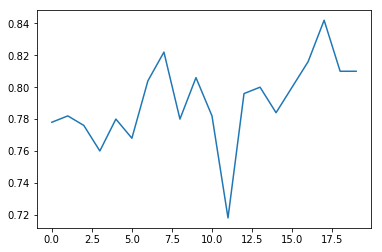

In [128]:
plt.plot(trainer.metrics['valid']['acc'])

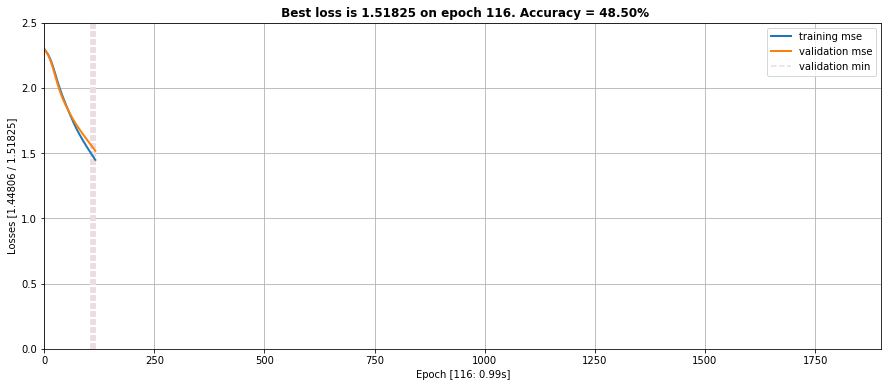

In [11]:
model_name = '../../models/SimpleRNN_MNIST'
fit_params = {
    'model_name': model_name,
    'loss': 'categorical_crossentropy',
    'opt':        RMSprop(lr=1e-6),
    'batch_size': 32, 
    'nepochs':    1900,
    'patience':   15,
    'ploss':      2.5,
    'reset':      False,
}

model,_ = train_network(model, x_train, y_train_oh, x_test, y_test_oh, **fit_params);

In [13]:
test_network(model_name, x_test, y_test_oh)

Model from epoch 116
[INFO] evaluating in the test data set ...
 128/1000 [==>...........................] - ETA: 0s
[INFO] accuracy on the test data set: 48.50% [1.51825]


In [14]:
yhat = model.predict_classes(x_test[0:10])

10/10 [==============================] - 0s


In [15]:
yhat

array([7, 6, 1, 6, 4, 1, 4, 8, 4, 8])

In [16]:
y_test[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)